<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Machine Learning Using Python (MEAFA Workshop)</h1>
<h2 align="center" style="margin-top:10px">Lesson 5: Trees and Random Forests</h2>
<br>

In this lesson we can consider a case study from customer relationship management to discuss decision trees and random forests.

<a href="Customer Acquisition Data">Customer Acquisition Data</a> <br>
<a href="#Exploratory-data-analysis">Exploratory Data Analysis</a> <br>
<a href="#Decision-Tree">Decision Tree</a> <br>
<a href="#Bagging">Bagging</a> <br>
<a href="#Random-Forest">Random Forest</a> <br>
<a href="#Extremely-Randomised-Trees">Extremely Randomised Trees</a> <br>
<a href="#Model-Selection">Model Selection</a> <br>
<a href="#Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Methods
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss

## Customer Retention Data

This dataset is taken from [Statistical Methods in Customer Relationship Management](http://onlinelibrary.wiley.com/book/10.1002/9781118349212), authored by  V. Kumar and J. Andrew Petersen.

**Business objective**: to predict which customers will end the relationship with the business.  

In [4]:
data = pd.read_excel('Datasets/CustomerChurn.xls', index_col=[0])
data['Churn'] = (data['Censor']==0).astype(int)
data.head()

,Duration,Censor,Avg_Ret_Exp,Avg_Ret_Exp_SQ,Industry,Revenue,Employees,Total_Crossbuy,Total_Freq,Total_Freq_SQ,Churn
Customer,,,,,,,,,,,
1,500,0,89.61,8029.9521,1,30.16,1240,6,16,256,1
2,730,1,49.89,2489.0121,0,39.80,166,6,10,100,0
3,730,1,40.70,1656.4900,0,54.93,1016,2,14,196,0
4,340,0,85.76,7354.7776,0,45.83,122,2,15,225,1
5,730,1,31.90,1017.6100,0,69.03,313,1,9,81,0


In [5]:
response='Churn'
predictors=['Avg_Ret_Exp', 'Revenue', 'Employees', 'Total_Crossbuy', 'Total_Freq', 'Industry']
data = data[[response]+predictors] # discarding variables that we will not use

index_train, index_test  = train_test_split(np.array(data.index), stratify=data[response], train_size=0.8, random_state=5)

train = data.loc[index_train,].copy()
test =  data.loc[index_test,:].copy()

y_train = train[response]
y_test = test[response]

X_train = train[predictors]
X_test = test[predictors]

##Exploratory Data Analysis

In [6]:
train.describe().round(2)

,Churn,Avg_Ret_Exp,Revenue,Employees,Total_Crossbuy,Total_Freq,Industry
count,400.00,400.00,400.00,400.00,400.00,400.00,400.00
mean,0.46,36.10,39.74,671.75,3.40,11.47,0.60
std,0.50,33.01,16.33,468.54,1.54,5.85,0.49
min,0.00,0.04,2.35,4.00,1.00,1.00,0.00
25%,0.00,10.08,27.86,286.25,2.00,6.00,0.00
50%,0.00,24.74,39.94,588.50,3.00,12.00,1.00
75%,1.00,57.24,51.69,1025.50,5.00,17.00,1.00
max,1.00,145.16,74.97,1950.00,6.00,21.00,1.00


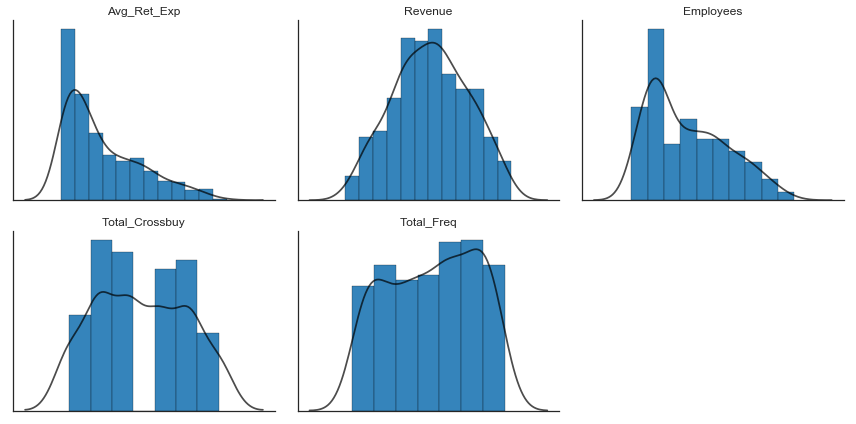

In [7]:
from statlearning import plot_histograms

plot_histograms(train[predictors[:-1]]) # excludes the last variable, since it is binary
plt.show()

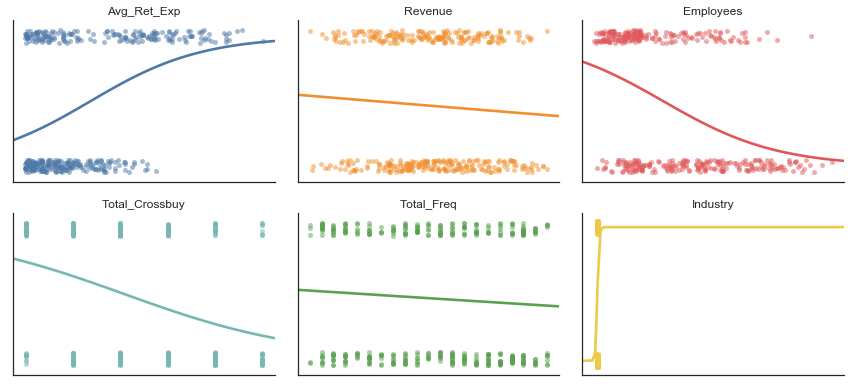

In [8]:
from statlearning import plot_logistic_regressions

with sns.color_palette(crayon):
    plot_logistic_regressions(train[predictors], train[response])
    plt.show()

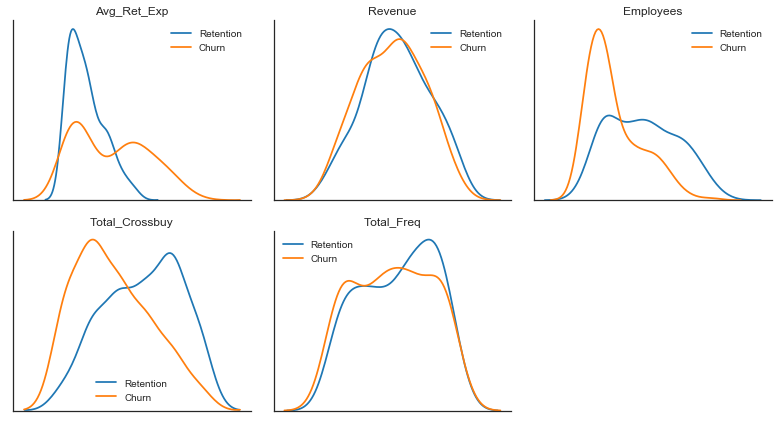

In [9]:
from statlearning import plot_conditional_distributions

plot_conditional_distributions(train[predictors[:-1]], y_train, labels=['Retention', 'Churn'])
plt.show()

In [10]:
table=pd.crosstab(train[response], train['Industry'])
table = (table/table.sum()).round(3)
table

Industry,0,1
Churn,,
0,0.597,0.494
1,0.403,0.506


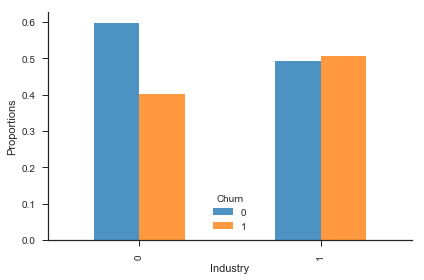

In [11]:
fig, ax = plt.subplots(figsize=(6,4))
(table.T).plot(kind='bar', alpha=0.8, ax=ax)
ax.set_xlabel('Industry')
ax.set_ylabel('Proportions')
ax.legend_.set_title('Churn')
plt.tight_layout()
sns.despine()
plt.show()

## Decision Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
tree = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=5)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

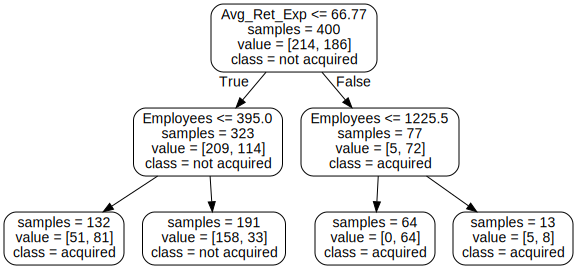

In [13]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, out_file=None, feature_names=predictors, impurity=False,
                           class_names=['not acquired','acquired'], rounded=True) 
graph = graphviz.Source(dot_data)
graph.render('tree01') # saves tree to a file
graph

In [14]:
%%time

model = DecisionTreeClassifier(criterion='entropy')

tuning_parameters = {
    'min_samples_leaf': [1,5,10,20,30,40,50],
}

tree_search = GridSearchCV(model, tuning_parameters, cv= 5 , return_train_score=False)
tree_search.fit(X_train, y_train)

tree = tree_search.best_estimator_

print('Best parameters found by grid search:', tree_search.best_params_, '\n')

Best parameters found by grid search: {'min_samples_leaf': 40} 

Wall time: 176 ms


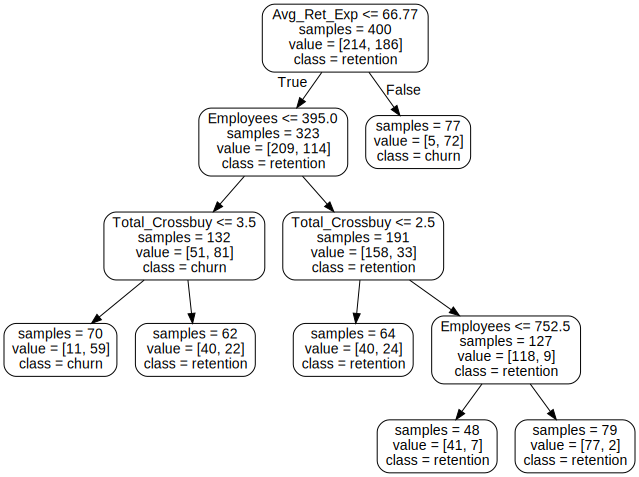

In [15]:
dot_data = export_graphviz(tree, out_file=None, feature_names=predictors, impurity=False,
                           class_names=['retention','churn'], rounded=True) 
graph = graphviz.Source(dot_data)
graph.render('tree02') # saves tree to a file
graph

## Bagging

In [16]:
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier(DecisionTreeClassifier(criterion='entropy'), n_estimators=1000, random_state=1)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=1000, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

## Random Forest

The syntax to fit a [random forest classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is the following. 

In [17]:
from sklearn.ensemble import  RandomForestClassifier
rf = RandomForestClassifier(criterion='entropy', max_features= 2, min_samples_leaf=5, n_estimators=1000, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

To tune the random forest, we should select a parameter that controls the size of the trees (such as the minimum number of observations in a terminal node) and the number of predictors that are sampled as candidate split variables at each node of a tree.  

In [18]:
%%time

model = RandomForestClassifier(criterion = 'entropy',  n_estimators=1000)

tuning_parameters = {
    'min_samples_leaf': [1, 5, 10, 20, 50],
    'max_features': np.arange(1, len(predictors)+1),
}

rf_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 16, return_train_score=False, n_jobs=4)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 1, 'max_features': 6} 

Wall time: 1min 27s


After tuning the random forest, we may want to increase the number of trees to improve accuracy. 

In [19]:
rf.n_estimators = 10000
rf.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

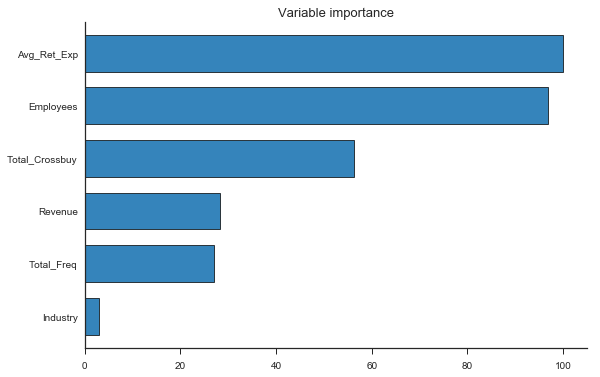

In [20]:
from statlearning import plot_feature_importance

plot_feature_importance(rf, predictors)
plt.show()

## Extremely Randomised Trees

In [21]:
from sklearn.ensemble import ExtraTreesClassifier

In [22]:
%%time

model = ExtraTreesClassifier(criterion = 'entropy',  n_estimators=1000)

tuning_parameters = {
    'min_samples_leaf': [1, 5, 10, 20, 50],
    'max_features': np.arange(1, len(predictors)+1),
}

xtrees_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 16, 
                                 return_train_score=False, n_jobs=4)
xtrees_search.fit(X_train, y_train)

xtrees = xtrees_search.best_estimator_

print('Best parameters found by randomised search:', xtrees_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 1, 'max_features': 4} 

Wall time: 1min 6s


In [23]:
xtrees.n_estimators = 10000
xtrees.fit(X_train, y_train) 

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features=4, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Model Selection

In [24]:
logit = LogisticRegression(C=1e3)
logit.fit(X_train, y_train)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [25]:
columns=['Error rate', 'Sensitivity', 'Specificity', 'AUC', 'Precision']
rows=['Logistic', 'Decision Tree', 'Bagged trees', 'Random forest', 'Extra Trees']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, tree, bag, rf, xtrees]

for i, method in enumerate(methods):
    
    y_prob = cross_val_predict(method, X_train, y_train, cv=10, method='predict_proba')
    y_pred = (y_prob[:,1] > 0.5).astype(int)

    confusion  = confusion_matrix(y_train, y_pred) 

    results.iloc[i,0]=  1 - accuracy_score(y_train, y_pred)
    results.iloc[i,1]=  confusion[1,1]/np.sum(confusion[1,:])
    results.iloc[i,2]=  confusion[0,0]/np.sum(confusion[0,:])
    results.iloc[i,3]=  roc_auc_score(y_train, y_prob[:,1])
    results.iloc[i,4]=  precision_score(y_train, y_pred)

results.round(3)

,Error rate,Sensitivity,Specificity,AUC,Precision
Logistic,0.175,0.796,0.850,0.916,0.822
Decision Tree,0.225,0.720,0.822,0.847,0.779
Bagged trees,0.162,0.812,0.860,0.926,0.834
Random forest,0.157,0.812,0.869,0.925,0.844
Extra Trees,0.155,0.801,0.883,0.934,0.856


## Model Evaluation

In [26]:
columns=['Error rate', 'Sensitivity', 'Specificity', 'AUC', 'Precision']
rows=['Logistic', 'Decision Tree', 'Bagged trees', 'Random forest', 'Extra Trees']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, tree, bag, rf, xtrees]

y_prob = np.zeros((len(test), len(rows)))

for i, method in enumerate(methods):
    
    y_pred = method.predict(X_test)
    y_prob[:, i] = method.predict_proba(X_test)[:,1]

    confusion  = confusion_matrix(y_test, y_pred) 

    results.iloc[i,0]=  1 - accuracy_score(y_test, y_pred)
    results.iloc[i,1]=  confusion[1,1]/np.sum(confusion[1,:])
    results.iloc[i,2]=  confusion[0,0]/np.sum(confusion[0,:])
    results.iloc[i,3]=  roc_auc_score(y_test, y_prob[:,i])
    results.iloc[i,4]=  precision_score(y_test, y_pred)

results.round(3)

,Error rate,Sensitivity,Specificity,AUC,Precision
Logistic,0.24,0.783,0.741,0.841,0.720
Decision Tree,0.26,0.609,0.852,0.815,0.778
Bagged trees,0.21,0.848,0.741,0.880,0.736
Random forest,0.22,0.848,0.722,0.882,0.722
Extra Trees,0.22,0.848,0.722,0.849,0.722


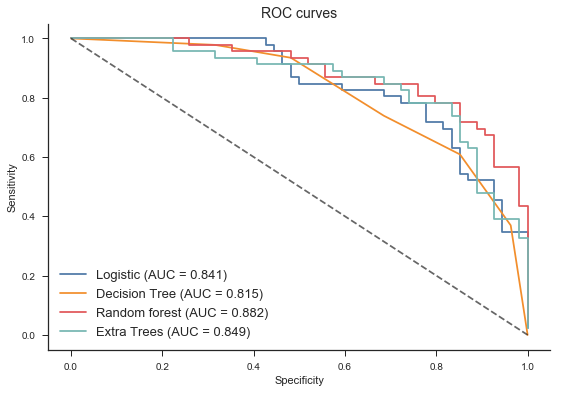

In [27]:
from statlearning import plot_roc_curves

with sns.color_palette(crayon):
    fig, ax = plot_roc_curves(y_test, y_prob[:,[0,1,3,4]], labels=pd.Series(rows).iloc[[0,1,3,4]])
    plt.show()